## Chapter 8: Decision Trees ##

In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import export_graphviz
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from IPython.display import Image
import StringIO, pydot
%matplotlib inline

In [4]:
carseats_df = pd.read_csv("../data/Carseats.csv")
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


(array([  6.,  16.,  47.,  83.,  89.,  79.,  40.,  29.,   8.,   3.]),
 array([  0.   ,   1.627,   3.254,   4.881,   6.508,   8.135,   9.762,
         11.389,  13.016,  14.643,  16.27 ]),
 <a list of 10 Patch objects>)

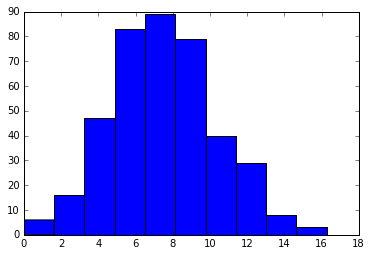

In [5]:
# Convert other string variables to numeric
carseats_df["ShelveLoc"] = pd.factorize(carseats_df["ShelveLoc"])[0]
carseats_df["Urban"] = pd.factorize(carseats_df["Urban"])[0]
carseats_df["US"] = pd.factorize(carseats_df["US"])[0]
# We want to add a binary response variable High (High Sales). We build a histogram to 
# determine the cut point.
plt.hist(carseats_df["Sales"])

In [6]:
# create a binary response variable HighSales and add to dataframe
carseats_df["High"] = carseats_df["Sales"].map(lambda x: 0 if x <= 8 else 1)
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,0,0,1
1,11.22,111,48,16,260,83,1,65,10,0,0,1
2,10.06,113,35,10,269,80,2,59,12,0,0,1
3,7.40,117,100,4,466,97,2,55,14,0,0,0
4,4.15,141,64,3,340,128,0,38,13,0,1,0


### Decision Tree Classifier ###

In [9]:
# fit a decision tree to predict High from the data. We remove Sales because High is
# derived from Sales and is thus correlated to the response
collist = [x for x in carseats_df.columns if x not in ('Sales', 'High')]
clf = DecisionTreeClassifier()
X = carseats_df[collist].values
y = carseats_df["High"].values
clf.fit(X, y)

# Visualize tree
dot_data = StringIO.StringIO()
export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

AttributeError: 'list' object has no attribute 'create_png'

In order to build the diagram above, I had to install pydot. I had some problems with pyparsing version mismatch which is described [here](http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will). The solution involved manually hacking the dot_parser.py file as [described here](https://code.google.com/p/pydot/issues/detail?id=81#c9).

One can also build a text representation of the tree using [ideas from this](http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree) and [this](http://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn) Stack Overflow page.

We evaluate a classifier by splitting our dataset into a 250/150 train/test set, training the tree on the training set and evaluating performance on the test set.

In [10]:
Xr, Xt, yr, yt = train_test_split(X, y, train_size=250, test_size=150, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(Xr, yr)
ypred = clf.predict(Xt)
(confusion_matrix(yt, ypred), accuracy_score(yt, ypred))

(array([[55, 27],
        [26, 42]]), 0.64666666666666661)

Pruning can reduce overfitting. Scikit-Learn DecisionTree classifier does not support pruning currently, but one can set the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem. Here we will use cross validation with different max depths to optimize the tree.

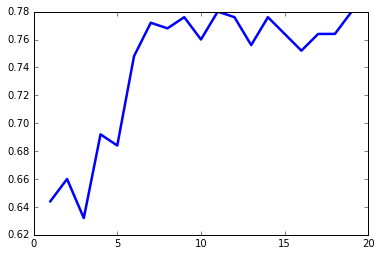

In [11]:
kfold = KFold(Xr.shape[0], n_folds=10)
accs = []
max_depths = range(1, 20)
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold:
        Xtrain, Xtest, ytrain, ytest = Xr[train], Xr[test], yr[train], yr[test]
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth
plt.plot(max_depths, accs, linewidth=2.5)

The lowest value of max_depth for which accuracy scores have reached a peak is around 7. We will now evaluate the "best" tree from cross validation against our held out test set.

In [12]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(Xr, yr)
ypred = clf.predict(Xt)
confusion_matrix(yt, ypred), accuracy_score(yt, ypred)

(array([[59, 23],
        [26, 42]]), 0.67333333333333334)

### Random Forests ###

Random Forests build lots of bushy trees, and then average them to reduce the variance. We will use Random Forests to predict medv (Median House Price in 1,000 dollars).

In [13]:
boston_df = pd.read_csv("../data/Boston.csv")
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [14]:
X = boston_df[boston_df.columns[:-1]].values
y = boston_df["medv"].values

# Split into training and test sets
Xr, Xt, yr, yt = train_test_split(X, y, train_size=300, test_size=202, random_state=42)

# Train random forest
reg = RandomForestRegressor(n_estimators=500, oob_score=True)
reg.fit(Xr, yr)
ypred = reg.predict(Xt)
mean_squared_error(yt, ypred), reg.oob_score_

(10.420899100198019, 0.82050348057250377)

We try to vary max_features (the number of features to consider when looking for the best split) from 1 to 13 and plot the results.

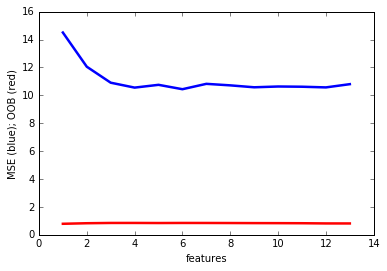

In [15]:
oob_scores = []
mses = []
num_feats = range(1, 14)
for num_feat in num_feats:
    reg = RandomForestRegressor(n_estimators=500, max_features=num_feat, oob_score=True)
    reg.fit(Xr, yr)
    ypred = reg.predict(Xt)
    mses.append(mean_squared_error(yt, ypred))
    oob_scores.append(reg.oob_score_)
plt.plot(num_feats, mses, color='b', linewidth=2.5)
plt.plot(num_feats, oob_scores, color='r', linewidth=2.5)
plt.xlabel("features")
plt.ylabel("MSE (blue); OOB (red)")

### Boosting ###

Boosting builds lots of small trees. Unlike Random Forests, each tree tries to make up for the deficiencies in the current ensemble. With Boosting, the number of trees is a tuning parameter. Using the same train/test split, we plot the variance of MSE against the number of trees.

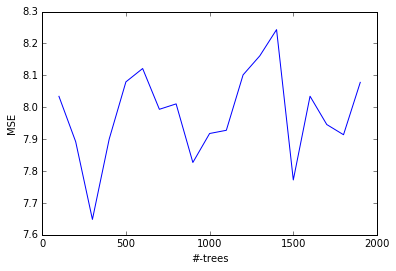

In [16]:
num_trees = range(100, 2000, 100)
mses = []
for num_tree in num_trees:
    reg = GradientBoostingRegressor(n_estimators=num_tree)
    reg.fit(Xr, yr)
    ypred = reg.predict(Xt)
    mses.append(mean_squared_error(yt, ypred))
plt.plot(num_trees, mses)
plt.xlabel("#-trees")
plt.ylabel("MSE")